# Gene Expression Cancer RNA-Seq Classification

In this notebook we shall examine a gene expression dataset of patients having different types of tumor and attempt to classify these tumors into one of five classes: BRCA, KIRC, COAD, LUAD and PRAD.
	
The collection of data is part of the RNA-Seq (HiSeq) PANCAN data set and can be found [here](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#).

The GitHub repository for this project can be found [here](https://github.com/nicksento/Gene-Expression-Cancer-Classification).

# Contents
[1.Import Libraries](#import)   
[2.Load the Data](#load)   
[3.Visualize the Data](#visual)   
[4.Prepare the Data for Machine Learning Algorithms](#prepare)      
&nbsp;&nbsp;&nbsp;[4.1.Stratified Shuffle Split](#strat)     
&nbsp;&nbsp;&nbsp;[4.2.Scale the Data](#scale)            
&nbsp;&nbsp;&nbsp;[4.3.Principal Component Analysis](#pca)               
[5.Train and Evaluate Machine Learning Models](#ml)                
&nbsp;&nbsp;&nbsp;[5.1.Gaussian Naive Bayes ](#ml1)              
&nbsp;&nbsp;&nbsp;[5.2.Logistic Regression ](#ml2)                        
&nbsp;&nbsp;&nbsp;[5.3.Support Vector Machines ](#ml3)           
&nbsp;&nbsp;&nbsp;[5.4.Random Forest](#ml4)               
[6.Conclusion](#conclusion)

## Import Libraries <a id='import'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
import chart_studio.plotly as py
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

## Load the Data <a id='load'></a>

In [3]:
data = pd.read_csv('data/data.csv')
data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [4]:
data.shape

(801, 20532)

Samples (instances) are stored row-wise. Variables (attributes) of each sample are RNA-Seq gene expression levels measured by illumina HiSeq platform. A dummy name (gene_XX) is given to each attribute. There are 20531 different genes and 801 samples.

In [5]:
y = pd.read_csv('data/labels.csv')
y.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [6]:
y.Class.unique()

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

There are 5 types of tumor in this dataset:   
- BRCA: Breast Cancer
- KIRC: Kidney Renal Clear Cell Carcinoma 
- COAD: Colon Adenocarcinom
- LUAD: Lung Adenocarcinoma  
- PRAD: Prostate Adenocarcinoma

In [7]:
y.Class.value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

In [8]:
y.Class.value_counts() / len(y)

BRCA    0.374532
KIRC    0.182272
LUAD    0.176030
PRAD    0.169788
COAD    0.097378
Name: Class, dtype: float64

## Visualize the Data <a id='visual'></a>

In [9]:
px.pie(y, names='Class',
       title='Tumor Types',
       color_discrete_sequence=px.colors.sequential.ice)

In [10]:
fig = px.histogram(y.Class, nbins=5, marginal="violin")
fig.show()

As we can see the dataset is not equally distributed so we will use stratified shuffle and split to seperate the data to train and test sets.

## Prepare the Data for Machine Learning Algorithms<a id='prepare'></a>

We will encode the class column so that it can be used in the machine learning algorithms.

In [11]:
y['Enc'] = y.Class.replace({'PRAD':0, 'LUAD':1, 'BRCA':2, 'KIRC':3, 'COAD':4})
labels = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']

In [12]:
y.head()

,Unnamed: 0,Class,Enc
0,sample_0,PRAD,0
1,sample_1,LUAD,1
2,sample_2,PRAD,0
3,sample_3,PRAD,0
4,sample_4,BRCA,2


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [14]:
na = 0
for i in data.columns:
    na +=  data[i].isna().sum()
print(na)

0


There are no null values in the dataset.

In [15]:
data.drop('Unnamed: 0', axis=1, inplace=True)
y.drop('Unnamed: 0', axis=1, inplace=True)

### Stratified Shuffle Split <a id='strat'></a>

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(y, y['Class']):
    X_train = data.loc[train_index]
    X_test = data.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]


In [17]:
def tumor_class_proportions(data):
    return data["Class"].value_counts() / len(data)

Xtrain, Xtest, ytrain, ytest = train_test_split(data, y , test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    #"Labels": labels,
    "Class": tumor_class_proportions(y),
    "Stratified": tumor_class_proportions(y_test),
    "Random": tumor_class_proportions(ytest),
}).sort_index()
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Class"] - 100
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Class"] - 100


In [18]:
compare_props

,Class,Stratified,Random,Strat. %error,Rand. %error
BRCA,0.374532,0.372671,0.378882,-0.496894,1.161491
COAD,0.097378,0.099379,0.105590,2.054467,8.432871
KIRC,0.182272,0.186335,0.155280,2.229218,-14.808985
LUAD,0.176030,0.173913,0.180124,-1.202590,2.325889
PRAD,0.169788,0.167702,0.180124,-1.228535,6.087870


### Scale the Data <a id='scale'></a>

In [19]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


Clearly there is some variation in the scales across the different features. Many machine learning models work much better with data that's on the same scale, so let's create a scaled version of the dataset.

In [20]:
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test) 

### Principal Component Analysis<a id='pca'></a>

With 20531 features, it would be a good practice to reduce the dimensionality of the dataset. **Principal Component Analysis (PCA)** is the most popular dimensionality reduction algorithm.     
We will use pca to preserve 95% of the variance.

In [21]:
pca = PCA(n_components=0.95)
#X_train.pca = pca.fit_transform(X_train)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [22]:
pca.n_components_

394

Around 95% of variance is explained by 394 features out of the 20531 features.

We can't plot something in 394 dimensions, so we will take a look at how PCA looks like when we pick the top 3 components.

In [23]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

In [24]:
fig = px.scatter_3d(y_train,
                   x=X_train_reduced[:, 0],
                   y=X_train_reduced[:, 1],
                   z=X_train_reduced[:, 2],
                   color=y_train.Class,
                   title = 'First three PCA directions',
                   opacity=0.7, width=700, height=500,
                   labels={'x':'1st eigenvector',
                           'y':'2nd eigenvector',
                           'z':'3rd eigenvector'})

fig

## Train and Evaluate Machine Learning Models<a id='ml'></a>

In [25]:
def draw_conf_mat(y_test, pred, model):
    cm_nb =  confusion_matrix(y_test.iloc[:,1], pred)
    ax = plt.subplot()
    sns.heatmap(cm_nb, annot=True, ax = ax, fmt='g', cmap='Greys') 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title( '{} Confusion Matrix'.format(type(model).__name__)) 
    ax.xaxis.set_ticklabels(labels) 
    ax.yaxis.set_ticklabels(labels, rotation=360)

In [26]:
def ml_algo(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.iloc[:,1])
    pred = model.predict(X_test)
    
    print(type(model).__name__, 
          'accuracy:', 
          round(accuracy_score(y_test.iloc[:,1], pred), 3))
    
    draw_conf_mat(y_test, pred, model)

### Gaussian Naive Bayes <a id='ml1'></a>

GaussianNB accuracy: 0.807


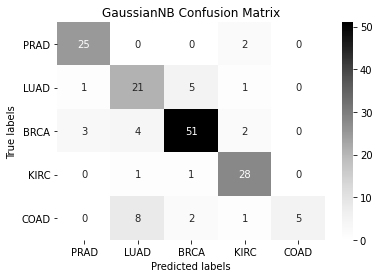

In [27]:
model = GaussianNB()
ml_algo(model, X_train, y_train, X_test, y_test)

### Logistic Regression <a id='ml2'></a>

LogisticRegression accuracy: 1.0


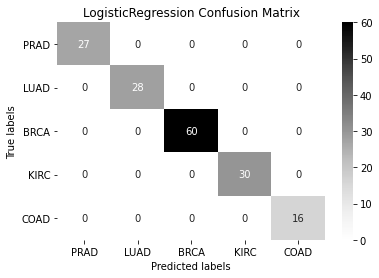

In [28]:
model = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
ml_algo(model, X_train_pca, y_train, X_test_pca, y_test)

### Support Vector Machines<a id='ml3'></a>

SVC accuracy: 0.994


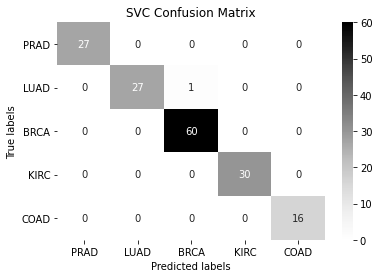

In [29]:
model = SVC(C=0.1,
            decision_function_shape='ovo',
            gamma=1, 
            kernel='linear')
ml_algo(model, X_train, y_train, X_test, y_test)

### Random Forest<a id='ml4'></a>

RandomForestClassifier accuracy: 0.975


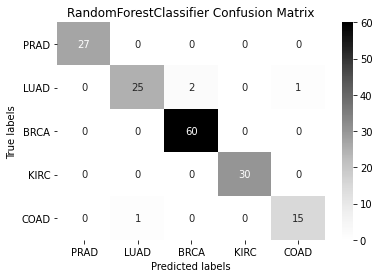

In [30]:
model = RandomForestClassifier(bootstrap=False,
                               max_features=0.6,
                               min_samples_leaf=8,
                               min_samples_split=3,
                               n_estimators=60,
                               random_state=0)
ml_algo(model, X_train_pca, y_train, X_test_pca, y_test)

## Conclusion<a id='conclusion'></a>

The best performance on this dataset was provided by Logistic Regrission using the reduced pca set as it had 100% accuracy.

The dataset we examined was well structured, without any missing values. The data manipulation we performed was minimal and the tumor types seemed to be quite distinct enabling the machine learning algorithms to perform optimally.